In [1]:
import pandas as pd
import random as rd
import numpy as np
import qgrid

from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.models import Model, load_model, Sequential

from tensorflow.keras import backend
from tensorflow.keras import initializers

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def visualize_field(field):
    """
    Visualizes the battle field in colored circles
    Input:
    - field: numpy array of floats, 7x6
    Output:
    - None
    """
    fig, ax = plt.subplots(figsize=(5, 7))

    ax.set_xlim((0, 10))
    ax.set_ylim((0, 13))

    circles = []

    for ii in range(7):
        for jj in range(6):
            if (field[ii, jj] == 0.2):
                clr = "red"
            elif (field[ii, jj] == 0.4):
                clr = "lightgreen"
            elif (field[ii, jj] == 0.6):
                clr = "cyan"
            else:
                clr = "purple"

            circles.append( mpatches.Circle((jj + 1, 7 - ii), radius=0.4, color=clr) )

    for circ in circles:
        ax.add_artist(circ)
        
    return


def make_move(field, move):
    """
    Physically moves plates according to the move
    Input:
    - field: numpy array of floats, 7x6
    - move: particular move to make, 1<=move<=142
    """
    start_y, start_x, direction = process_move_142(move)
    
    if (direction == "down"):
        end_x = start_x
        end_y = start_y + 1
    elif (direction == "up"):
        end_x = start_x
        end_y = start_y - 1
    elif (direction == "left"):
        end_x = start_x - 1
        end_y = start_y 
    else:
        end_x = start_x + 1
        end_y = start_y 

    # Swap two plates and create new (modified) field
    new_field = np.array(field)
    source_color = field[start_y - 1, start_x - 1]
    new_field[start_y - 1, start_x - 1] = field[end_y - 1, end_x - 1]
    new_field[end_y - 1, end_x - 1] = source_color
        
    return new_field


def process_move_142(move):
    """
    There are total 142 possible moves:
    - along the vertical axis: 6 + 5*12 + 6 = 6*12 = 72
    - along the norizontal axis: 7 + 4*14 + 7 = 5*14 = 70
    
    The _move_ parameter:
    Vertical moves:
    move in 1-6: row 1, column _move_, down
    move in 7-66: row (move - 7 // 12) + 2, column (((move - 7) % 12) // 2) + 1, direction _move_ % 2 == 0 - up, otherwise - down
    move in 67-72: row 7, column (move - 66), up
    
    Horizontal moves:
    move in 73-79: row (move - 72), column 1, right
    move in 80-135: row ((move - 80) % 14) // 2 + 1, column ((move - 80) // 14) + 2, direction _move_ % 2 == 0 - left, otherwise - right
    move in 136-142: row (move - 135), column 6, left    
    
    Input:
    - move: move code, 1-142, int
    Output:
    - row: row where the moved object located, 1-7, int
    - column: row where the moved object located, 1-6, int
    - direction: "up"/"down"/"left"/"right", string
    """
    # Process move
    if (move in range(1, 7)):
        row = 1
        column = move
        direction = "down"
    elif (move in range(7, 67)):
        row = ((move - 7) // 12) + 2
        column = (((move - 7) % 12) // 2) + 1
        direction = "up" if (move % 2 == 0) else "down"
    elif (move in range(67, 73)):
        row = 7
        column = move - 66
        direction = "up"
    elif (move in range(73, 80)):
        row = move - 72
        column = 1
        direction = "right"
    elif (move in range(80, 136)):
        row = (((move - 80) % 14) // 2) + 1
        column = ((move - 80) // 14) + 2
        direction = "left" if (move % 2 == 0) else "right"
    else:
        row = move - 135
        column = 6
        direction = "left"
    
    return row, column, direction


def predict_max_score(field, aero_cnn, number_of_moves, debug_flag = False):
    """
    TODO 
    """
    X_data = ()
           
    for move in range(1, number_of_moves + 1):
        swapped = make_move(np.array(field), move)
        X_data = X_data + ( swapped, )
    
    # Теперь выбираем наиболее успешый ход из всех успешных
    X_data = np.expand_dims(np.stack(X_data, axis=0), axis=3)
    
    prediction = aero_cnn.predict(X_data)
    
    if (debug_flag):
        print("DEBUG", prediction)
    
    best_move_score = prediction.max()
    best_move_number = prediction.argmax() + 1
    
    return best_move_score, best_move_number




In [3]:
# Загрузим ранее созданную модель
aero_cnn = load_model('Aero_CNN_v1')

In [4]:
# Инициализация переменных
field = np.zeros((7, 6))

In [8]:
df = pd.DataFrame(field)
qgrid_widget = qgrid.show_grid(df, show_toolbar=True)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

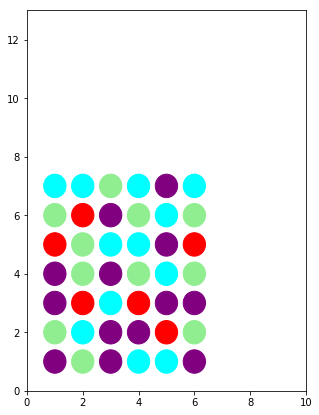

In [70]:
updated_df = qgrid_widget.get_changed_df()
updated_field = updated_df.values
visualize_field(updated_field)

In [69]:
reward, move = predict_max_score(updated_field, aero_cnn, 142)
print(process_move_142(move), ", predicted score =", reward)

(3, 4, 'down') , predicted score = 9.955138
